In [1]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns
%matplotlib inline

import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.utils import to_categorical 


import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.utils import class_weight
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

from livelossplot.inputs.tf_keras import PlotLossesCallback




from scipy.io import wavfile as wav
import struct
import IPython.display as ipd

plt.style.use('ggplot')
import plotly.graph_objects as go

In [2]:
# constants

NP_DATASET = 'dataset_AllFeatures.npy'
DATA_PATH = "../../../datasets/UrbanSound8K/"
#DATA_PATH = "../../../data_sets/UrbanSound8K/"
CSV_DATASET_PATH = "metadata/"
CSV_FILE  = "UrbanSound8K.csv"
AUDIO_DATASET_PATH = "audio/"


In [3]:
#Load datasets
csv_dataset = pd.read_csv(DATA_PATH+CSV_DATASET_PATH+CSV_FILE)


In [4]:
#para melhor gestão memória GPU por parte do tensorflow

def set_keras_backend(backend):
    print("A acertar o backend e libertar memória da grafica")
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
    if backend == "tensorflow":
        # Allow memory growth for the GPU
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print(physical_devices)
        tf.config.experimental.set_memory_growth(physical_devices[0], True)


def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

set_keras_backend("tensorflow")

A acertar o backend e libertar memória da grafica
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
appended = []
for i in range(1,11):
    appended.append(csv_dataset[csv_dataset.fold == i]['class'].value_counts())
    
class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

,index,jackhammer,children_playing,air_conditioner,dog_bark,drilling,street_music,engine_idling,siren,car_horn,gun_shot
0,fold1,120,100,100,100,100,100,96,86,36,35
1,fold2,120,100,100,100,100,100,100,91,42,35
2,fold3,120,100,100,100,100,100,107,119,43,36
3,fold4,120,100,100,100,100,100,107,166,59,38
4,fold5,120,100,100,100,100,100,107,71,98,40
5,fold6,68,100,100,100,100,100,107,74,28,46
6,fold7,76,100,100,100,100,100,106,77,28,51
7,fold8,78,100,100,100,100,100,88,80,30,30
8,fold9,82,100,100,100,100,100,89,82,32,31
9,fold10,96,100,100,100,100,100,93,83,33,32


In [6]:
# Read wav file function
def path_class(filename):
    excerpt = csv_dataset[csv_dataset['slice_file_name'] == filename]
    path_name = os.path.join(DATA_PATH, AUDIO_DATASET_PATH, 'fold'+str(excerpt.fold.values[0]), filename)
    return path_name, excerpt['class'].values[0]


In [7]:
# Drawing wav function
def wav_plotter(full_path, class_label):   
    rate, wav_sample = wav.read(full_path)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    print('sampling rate: ',rate,'Hz')
    print('bit depth: ',bit_depth)
    print('number of channels: ',wav_sample.shape[1])
    print('duration: ',wav_sample.shape[0]/rate,' second')
    print('number of samples: ',len(wav_sample))
    print('class: ',class_label)
    plt.figure(figsize=(12, 4))
    plt.plot(wav_sample) 
    return ipd.Audio(full_path)

sampling rate:  44100 Hz
bit depth:  16
number of channels:  2
duration:  4.0  second
number of samples:  176400
class:  dog_bark


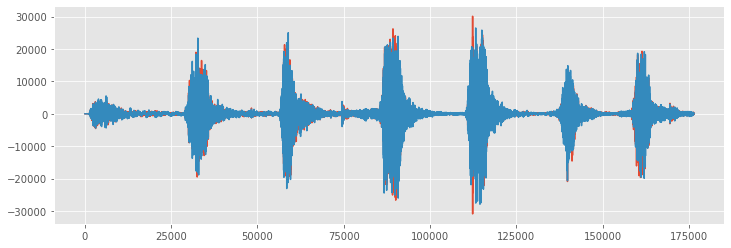

In [8]:
# Give an example of sound to show
fullpath, label = path_class('100652-3-0-0.wav')
wav_plotter(fullpath,label)

In [9]:
dataset = np.zeros(shape = (csv_dataset.shape[0],6),dtype = object)
dataset.shape # dataset is the array in which value will be saved

(8732, 6)

In [10]:
l = np.load(NP_DATASET,allow_pickle= True)

In [11]:
print(l.shape)

(8732, 6)


In [12]:
def load_data(np_dataset):
    
    std = StandardScaler()
    data = pd.DataFrame(np.load(np_dataset,allow_pickle= True))
    data.columns = ['mfccs', 'chroma', 'mel', 'contrast', 'tonnetz', 'label']
    #print(data.head())
    mfcss = np.array(data.mfccs.tolist())
    chroma = np.array(data.chroma.tolist())
    mel = np.array(data.mel.tolist())
    contrast = np.array(data.contrast.tolist())
    tonnetz = np.array(data.tonnetz.tolist())
    features = np.hstack([mfcss, chroma, mel, contrast, tonnetz])
    #print(features)
    X = np.array(features)
    std.fit(X)
    Y = np.array(data.label.tolist())

    X.shape,Y.shape,X[0].reshape(1,X[0].shape[0]).shape
    
    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
    lb = LabelEncoder()
    print('x_train',x_train.shape)
    print('y_train',y_train.shape)
    print('x_test',x_test.shape)
    print('y_test',y_test.shape)
    return (x_train, y_train, x_test, y_test)

    
(x_train, y_train, x_test, y_test) = load_data(NP_DATASET)
air_con=np.count_nonzero(y_train == 'air_conditioner')
car_horn = np.count_nonzero(y_train == 'car_horn')
children_playing = np.count_nonzero(y_train == 'children_playing')
dog_bark= np.count_nonzero(y_train == 'dog_bark')
drilling= np.count_nonzero(y_train == 'drilling')
engine_idling= np.count_nonzero(y_train == 'engine_idling')
gun_shot= np.count_nonzero(y_train == 'gun_shot')
jackhammer= np.count_nonzero(y_train == 'jackhammer')
siren= np.count_nonzero(y_train == 'siren')
street_music= np.count_nonzero(y_train == 'street_music')
print("air_con: ", air_con)
print("car_horn: ", car_horn)
print("children_playing: ", children_playing)
print("drilling: ", drilling)
print("engine_idling: ", engine_idling)
print("gun_shot: ", gun_shot)
print("jackhammer: ", jackhammer)
print("siren: ", siren)
print("street_music: ", street_music)
print("dog_bark: ", dog_bark)


mu=1 #factor a ajustar para os vvalores não ficarem muito elevados
sum = air_con + car_horn + children_playing + drilling + engine_idling + gun_shot + jackhammer + siren + street_music + dog_bark
score_air_con = math.log(mu*(sum)/float(air_con))
score_car_horn = math.log(mu*(sum)/float(car_horn))
score_children_playing = math.log(mu*(sum)/float(children_playing))
score_drilling = math.log(mu*(sum)/float(drilling))
score_engine_idling = math.log(mu*(sum)/float(engine_idling))
score_gun_shot = math.log(mu*(sum)/float(gun_shot))
score_jackhammer = math.log(mu*(sum)/float(jackhammer))
score_siren = math.log(mu*(sum)/float(siren))
score_street_music = math.log(mu*(sum)/float(street_music))
score_dog_bark = math.log(mu*(sum)/float(dog_bark))


class_weights = {0: score_air_con, 1: score_car_horn, 2:score_children_playing , 3:score_dog_bark, 4: score_drilling, 5: 
                score_engine_idling, 6: score_gun_shot, 7: score_jackhammer, 8: score_siren, 9: score_street_music}
print(class_weights)


x_train (6985, 193)
y_train (6985,)
x_test (1747, 193)
y_test (1747,)
air_con:  794
car_horn:  341
children_playing:  799
drilling:  786
engine_idling:  806
gun_shot:  301
jackhammer:  809
siren:  752
street_music:  790
dog_bark:  807
{0: 2.1744368104439267, 1: 3.0196377944075454, 2: 2.1681593259247878, 3: 2.1581966034211133, 4: 2.184563479261856, 5: 2.159436529184434, 6: 3.1444100069421865, 7: 2.1557213546325706, 8: 2.2287839477412223, 9: 2.179487326229995}


casos_treino: 6985
air_con_train:  794
car_horn_train:  341
children_playing_train:  799
drilling_train:  786
engine_idling_train:  806
gun_shot_train:  301
jackhammer_train:  809
siren_train:  752
street_music_train:  790
dog_bark_train:  807
casos_teste: 1747
air_con_test:  206
car_horn_test:  88
children_playing_test:  201
drilling_test:  214
engine_idling_test:  194
gun_shot_test:  73
jackhammer_test:  191
siren_test:  177
street_music_test:  210
dog_bark_test:  193


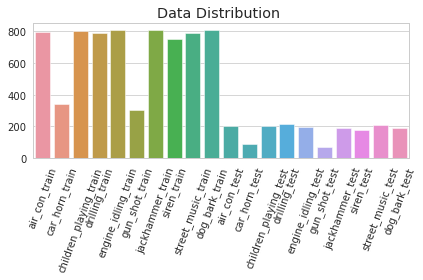

In [13]:
 def visualize_holdout_balance(y_train, y_test):
    sns.set_style('whitegrid')
    
    casos_treino=len(y_train) 
    air_con_train=np.count_nonzero(y_train == 'air_conditioner')
    car_horn_train = np.count_nonzero(y_train == 'car_horn')
    children_playing_train = np.count_nonzero(y_train == 'children_playing')
    dog_bark_train= np.count_nonzero(y_train == 'dog_bark')
    drilling_train= np.count_nonzero(y_train == 'drilling')
    engine_idling_train= np.count_nonzero(y_train == 'engine_idling')
    gun_shot_train= np.count_nonzero(y_train == 'gun_shot')
    jackhammer_train= np.count_nonzero(y_train == 'jackhammer')
    siren_train= np.count_nonzero(y_train == 'siren')
    street_music_train= np.count_nonzero(y_train == 'street_music')
    print("casos_treino:",casos_treino)
    print("air_con_train: ", air_con_train)
    print("car_horn_train: ", car_horn_train)
    print("children_playing_train: ", children_playing_train)
    print("drilling_train: ", drilling_train)
    print("engine_idling_train: ", engine_idling_train)
    print("gun_shot_train: ", gun_shot_train)
    print("jackhammer_train: ", jackhammer_train)
    print("siren_train: ", siren_train)
    print("street_music_train: ", street_music_train)
    print("dog_bark_train: ", dog_bark_train)

    
    casos_test=len(y_test)
    air_con_test=np.count_nonzero(y_test == 'air_conditioner')
    car_horn_test = np.count_nonzero(y_test == 'car_horn')
    children_playing_test = np.count_nonzero(y_test == 'children_playing')
    dog_bark_test= np.count_nonzero(y_test == 'dog_bark')
    drilling_test= np.count_nonzero(y_test == 'drilling')
    engine_idling_test= np.count_nonzero(y_test == 'engine_idling')
    gun_shot_test= np.count_nonzero(y_test == 'gun_shot')
    jackhammer_test= np.count_nonzero(y_test == 'jackhammer')
    siren_test= np.count_nonzero(y_test == 'siren')
    street_music_test= np.count_nonzero(y_test == 'street_music')
    
    print("casos_teste:",casos_test)
    
    print("air_con_test: ", air_con_test)
    print("car_horn_test: ", car_horn_test)
    print("children_playing_test: ", children_playing_test)
    print("drilling_test: ", drilling_test)
    print("engine_idling_test: ", engine_idling_test)
    print("gun_shot_test: ", gun_shot_test)
    print("jackhammer_test: ", jackhammer_test)
    print("siren_test: ", siren_test)
    print("street_music_test: ", street_music_test)
    print("dog_bark_test: ", dog_bark_test)


    grafico=sns.barplot(x=['air_con_train','car_horn_train', 'children_playing_train', 'drilling_train', 
                           'engine_idling_train', 'gun_shot_train', 'jackhammer_train', 'siren_train', 
                           'street_music_train', 'dog_bark_train', 'air_con_test','car_horn_test', 'children_playing_test',
                          'drilling_test', 'engine_idling_test', 'gun_shot_test', 'jackhammer_test', 'siren_test', 
                          'street_music_test', 'dog_bark_test'],
                        y=[air_con_train,car_horn_train, children_playing_train, drilling_train, engine_idling_train, 
                           gun_shot_train, jackhammer_train, siren_train, street_music_train, dog_bark_train, 
                           air_con_test,car_horn_test, children_playing_test, drilling_test, engine_idling_test, 
                           gun_shot_test, jackhammer_test, siren_test, street_music_test, dog_bark_test])
    grafico.set_title('Data Distribution ')
    plt.xticks(rotation=70)
    plt.tight_layout()
    #plt.savefig('data_distribution_MLP.png')
    plt.show() 
    

visualize_holdout_balance(y_train, y_test)

In [14]:
lb = LabelEncoder()

y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))


train = np.argmax(y_train,axis =  1)
test = np.argmax(y_test,axis =  1)

In [17]:
print(x_train.shape)
print(train.shape)
print(x_test.shape)
print(test.shape)

(6985, 193)
(6985,)
(1747, 193)
(1747,)


In [18]:
clf_xgb = xgb.XGBClassifier(objective='multi:softmax', seed=42,
    learning_rate=0.3,
    n_estimators=100,
    max_depth=6,
    min_child_weight=1,
    gamma=0,
    subsample=1,
    colsample_bytree=1,
    scale_pos_weight=1)

#(x_train, y_train, x_test, y_test)

clf_xgb.fit(x_train,train.ravel(),
           verbose=False,
            early_stopping_rounds=50,
            eval_metric='merror',
            eval_set=[(x_test, test.ravel())])

#clf_xgb.fit(x_train,train)

y_predict = clf_xgb.predict(x_test)
y_train_predict = clf_xgb.predict(x_train)

print(f'Training accuracy:        {accuracy_score(train,  y_train_predict)*100: .2f}%')
print(f'Validation accuracy:      {accuracy_score(test, y_predict)*100: .2f}%')

[19:08:13] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Training accuracy:         100.00%
Validation accuracy:       92.96%


Sensitivity:               100.00%
Specificity:               100.00%
Positive predictive value: 100.00%
Negative predictive value: 100.00%


Text(0.5, 50.09375, 'Predicted label')

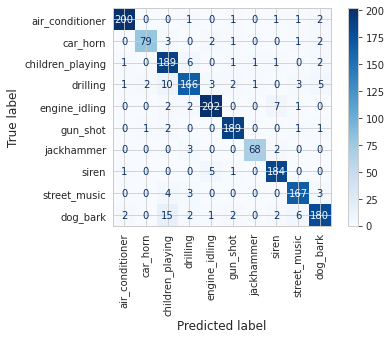

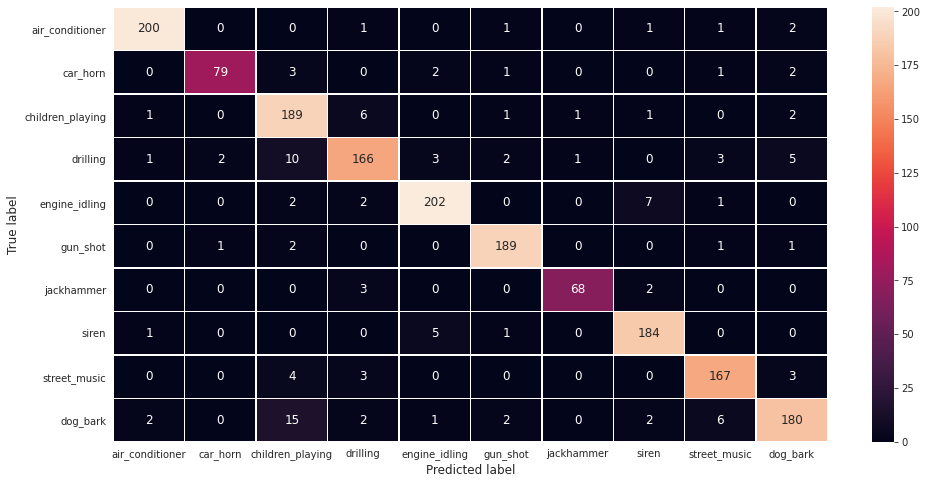

In [19]:
plot_confusion_matrix(clf_xgb,
                    x_test,
                    test,
                    values_format='d',
                    cmap='Blues',
                    display_labels=['air_conditioner','car_horn', 'children_playing', 'drilling','engine_idling', 
                                    'gun_shot', 'jackhammer', 'siren','street_music', 'dog_bark'], xticks_rotation='vertical')

cm = confusion_matrix(test, y_predict)
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TP = cm[1,1]
sensitivity = (TP/(TP + FN))*100
specificity = (TN/(TN + FP))*100
PPV = (TP/(TP + FP))*100
NPV = (TN/(TN + FN))*100
print(f'Sensitivity:              {sensitivity: .2f}%')
print(f'Specificity:              {specificity: .2f}%')
print(f'Positive predictive value:{PPV: .2f}%')
print(f'Negative predictive value:{NPV: .2f}%')

plt.figure(figsize = (16,8))
sns.heatmap(cm,annot=True,xticklabels=['air_conditioner','car_horn', 'children_playing', 'drilling','engine_idling', 
                                    'gun_shot', 'jackhammer', 'siren','street_music', 'dog_bark'],yticklabels=['air_conditioner','car_horn', 'children_playing', 'drilling','engine_idling', 
                                    'gun_shot', 'jackhammer', 'siren','street_music', 'dog_bark'], annot_kws={"size": 12}, fmt='g', linewidths=.5)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [20]:
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

In [21]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return indices

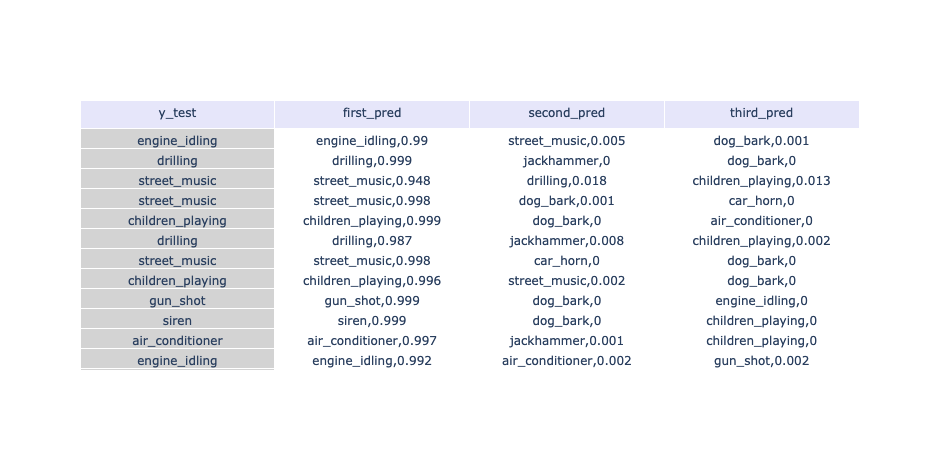

In [26]:
def print_series_prediction(sound, label):
    sounds = []
    first_preds = []
    first_percent = []
    second_preds = []
    second_percent = []
    third_preds = []
    third_percent = []
    for i in range(len(sound)): #para imprimir tabela de previsoes
        predictions = clf_xgb.predict_proba(sound)
        predic = largest_indices(predictions[i], 3)
        percentage = predictions[i][predic]
        
        sounds.append(label[i])

        
        first_preds.append((lb.inverse_transform(predic)[0] , truncate(percentage[0],3)))
        second_preds.append((lb.inverse_transform(predic)[1] , truncate(percentage[1],3)))
        third_preds.append((lb.inverse_transform(predic)[2] , truncate(percentage[2],3)))
       
    data = {'y_test':  sounds,
            'first_pred': first_preds,
            'second_pred': second_preds,
            'third_pred': third_preds
           }
    df = pd.DataFrame(data)
    fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                fill_color='lavender',
                align='center'),
    cells=dict(values=[df.y_test, df.first_pred
                       ,df.second_pred, df.third_pred
                      ],
               #fill_color='lightgrey',
               fill=dict(color=['lightgrey', 'white']),
               align='center'))])

    fig.show()


print_series_prediction(x_test,  lb.inverse_transform(test))